In [1]:
%matplotlib inline

## Load the MNIST digit dataset

In [2]:
#import pylab as plt
from sklearn.datasets import fetch_openml

# Download the MNIST dataset
X, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)

# normalize the sample into [0, 1]
X *= 1. / 255

## Testing BCM model on MNIST dataset

In [3]:
from plasticity.model import BCM

model = BCM(outputs=100, num_epochs=10, batch_size=100, interaction_strenght=0.)
model.fit(X)

  1%|▏         | 9/700 [00:00<00:08, 85.16it/s]

Epoch 1/10


  1%|          | 6/700 [00:00<00:11, 59.69it/s]

Epoch 2/10


  1%|          | 5/700 [00:00<00:18, 36.63it/s]

Epoch 3/10


  1%|          | 6/700 [00:00<00:12, 54.26it/s]

Epoch 4/10


  1%|          | 8/700 [00:00<00:09, 69.42it/s]

Epoch 5/10


  1%|          | 6/700 [00:00<00:12, 54.57it/s]

Epoch 6/10


  1%|          | 6/700 [00:00<00:12, 57.59it/s]

Epoch 7/10


  1%|          | 4/700 [00:00<00:17, 39.03it/s]

Epoch 8/10


  1%|          | 7/700 [00:00<00:09, 69.92it/s]

Epoch 9/10


  1%|          | 6/700 [00:00<00:12, 55.62it/s]

Epoch 10/10


100%|██████████| 700/700 [00:10<00:00, 66.23it/s]


BCM(interaction_strenght=0.0, sigma=1.0, num_epochs=10, mu=0.0, outputs=100, epsilon=0.02, precision=1e-30, activation=<function Logistic.activate at 0x7f87b1bf0b80>, seed=42, batch_size=100)

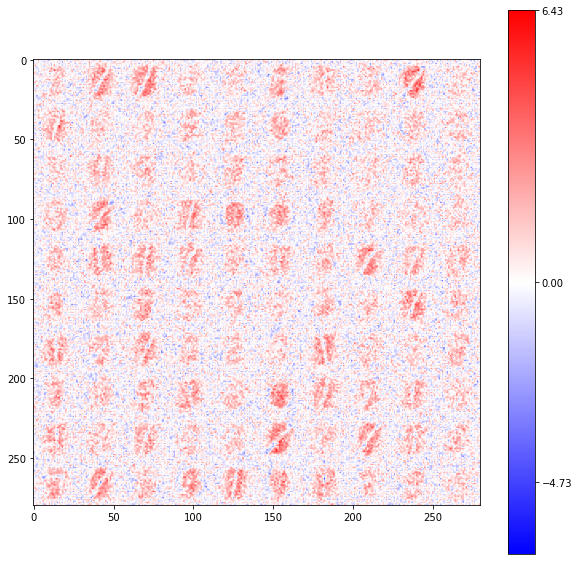

In [5]:
from plasticity.utils import view_weights

view_weights (model.weights, dims=(28, 28))

## Testing Hopfield model on MNIST dataset

In [5]:
from plasticity.model import Hopfield

model = Hopfield(outputs=100, num_epochs=10)
model.fit(X)

Epoch 1/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 498.10it/s]


Epoch 2/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 500.51it/s]


Epoch 3/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 500.67it/s]


Epoch 4/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 503.01it/s]


Epoch 5/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 501.22it/s]


Epoch 6/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 500.43it/s]


Epoch 7/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 502.26it/s]


Epoch 8/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 500.49it/s]


Epoch 9/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 500.40it/s]


Epoch 10/10


100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 502.75it/s]


Hopfield(epsilon=0.02, sigma=1.0, delta=0.4, outputs=100, num_epochs=10, seed=42, precision=1e-30, batch_size=100, p=2.0, k=2, mu=0.0)

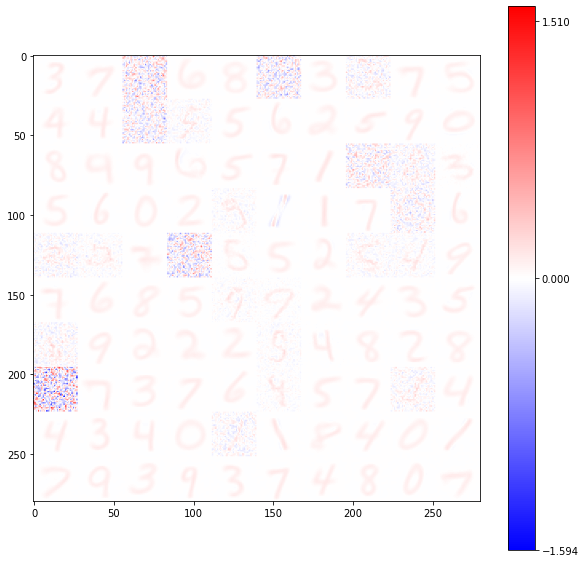

In [6]:
from plasticity.utils import view_weights

view_weights (model.weights, dims=(28, 28))